# Hard magnet material exploration

## Introduction

- In this notebook we explore hard magnet properties such as Hc as function of material and temperature.
- For more in-depth explanations we recommend starting with the [hard magnet tutorial](hard-magnet-tutorial.ipynb).

Requirements:
- Software: `mammos`, `esys-escript`
- Basic understanding of [mammos-units](https://mammos-project.github.io/mammos/examples/mammos-units/quickstart.html) and [mammos-entity](https://mammos-project.github.io/mammos/examples/mammos-entity/quickstart.html)

In [1]:
%config InlineBackend.figure_format = "retina"

import math
import time

import mammos_analysis
import mammos_dft
import mammos_mumag
import mammos_spindynamics
import mammos_units as u
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colormaps

In [2]:
# Allow convenient conversions between A/m and T
u.set_enabled_equivalencies(u.magnetic_flux_field());

## Select material

**Change the index in the first line of the following cell to select one of the available materials:**

In [3]:
index = 1  # select desired material

match index:
    case 1:
        material = "Co2Fe2H4"
        H_max = (5 * u.T).to("A/m")
    case 2:
        material = "Fe16N2"
        H_max = (1.2 * u.T).to("A/m")

material

'Co2Fe2H4'

## Load data from DFT and spindynamics databases

In [4]:
results_dft = mammos_dft.db.get_micromagnetic_properties(material)

In [5]:
results_spindynamics = mammos_spindynamics.db.get_spontaneous_magnetization(material)

## Calculate micromagnetic intrinsic properties using Kuz’min formula

In [6]:
results_kuzmin = mammos_analysis.kuzmin_properties(
    T=results_spindynamics.T,
    Ms=results_spindynamics.Ms,
    K1_0=results_dft.Ku_0,
)

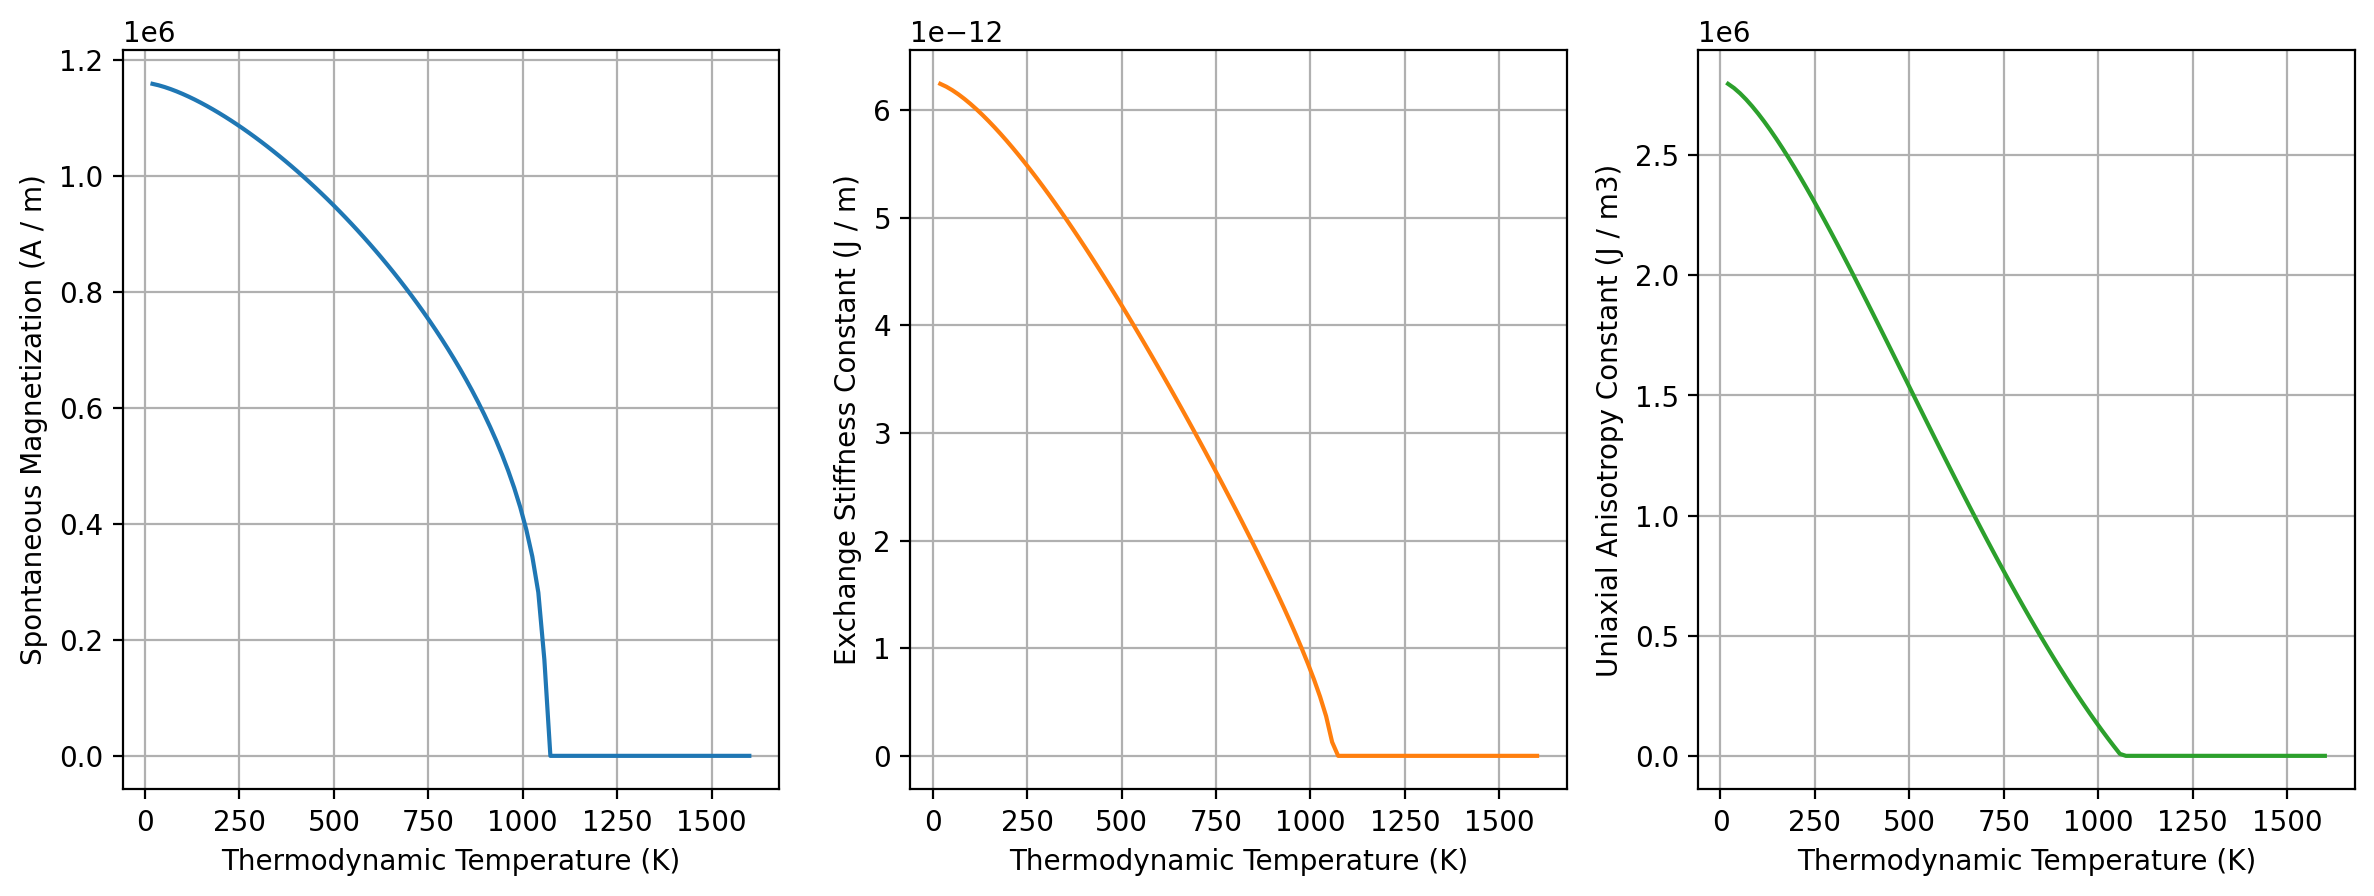

In [7]:
results_kuzmin.plot();

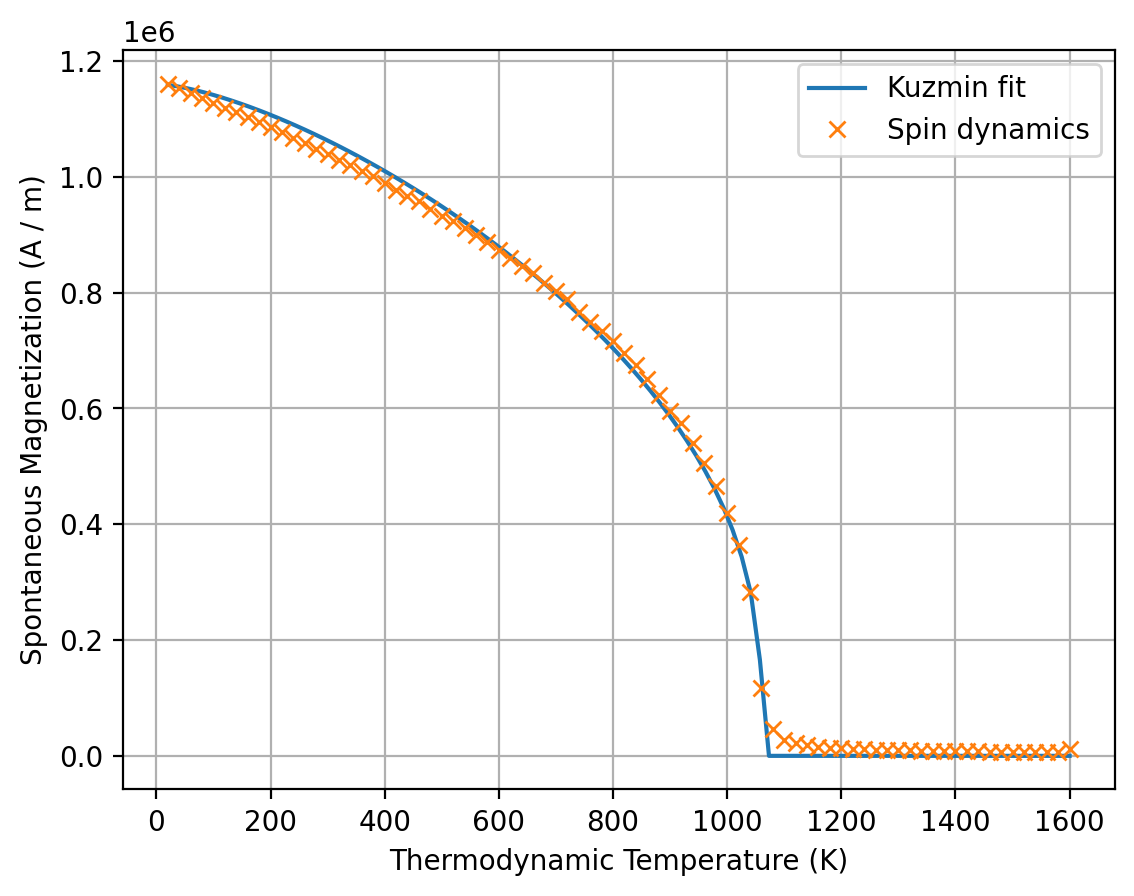

In [8]:
ax = results_kuzmin.Ms.plot(label="Kuzmin fit")
results_spindynamics.plot(ax=ax, label="Spin dynamics");

## Compute Hc(T)

In [9]:
T = np.linspace(0, 1.1 * results_kuzmin.Tc.q, 7)

simulations = []
start_time = time.time()
for temperature in T:
    print(f"Running simulation for T={temperature:.0f}, {int(time.time() - start_time)} seconds")
    results_hysteresis = mammos_mumag.hysteresis.run(
        mesh="cube20_singlegrain_msize2",
        Ms=results_kuzmin.Ms(temperature),
        A=results_kuzmin.A(temperature),
        K1=results_kuzmin.K1(temperature),
        hstart=H_max,
        hfinal=-H_max,
        hnsteps=30,
    )
    simulations.append(results_hysteresis)

Running simulation for T=0 K, 0 seconds
Running simulation for T=195 K, 23 seconds
Running simulation for T=389 K, 46 seconds
Running simulation for T=584 K, 68 seconds
Running simulation for T=778 K, 93 seconds
Running simulation for T=973 K, 119 seconds
Running simulation for T=1168 K, 146 seconds


We can now use `mammos_analysis.hysteresis` as shown before to extract Hc for all simulations and visualize Hc(T):

In [10]:
Hcs = []
for res in simulations:
    cf = mammos_analysis.hysteresis.extract_coercive_field(H=res.H, M=res.M).value
    if np.isnan(cf):  # Above Tc
        cf = 0
    Hcs.append(cf)

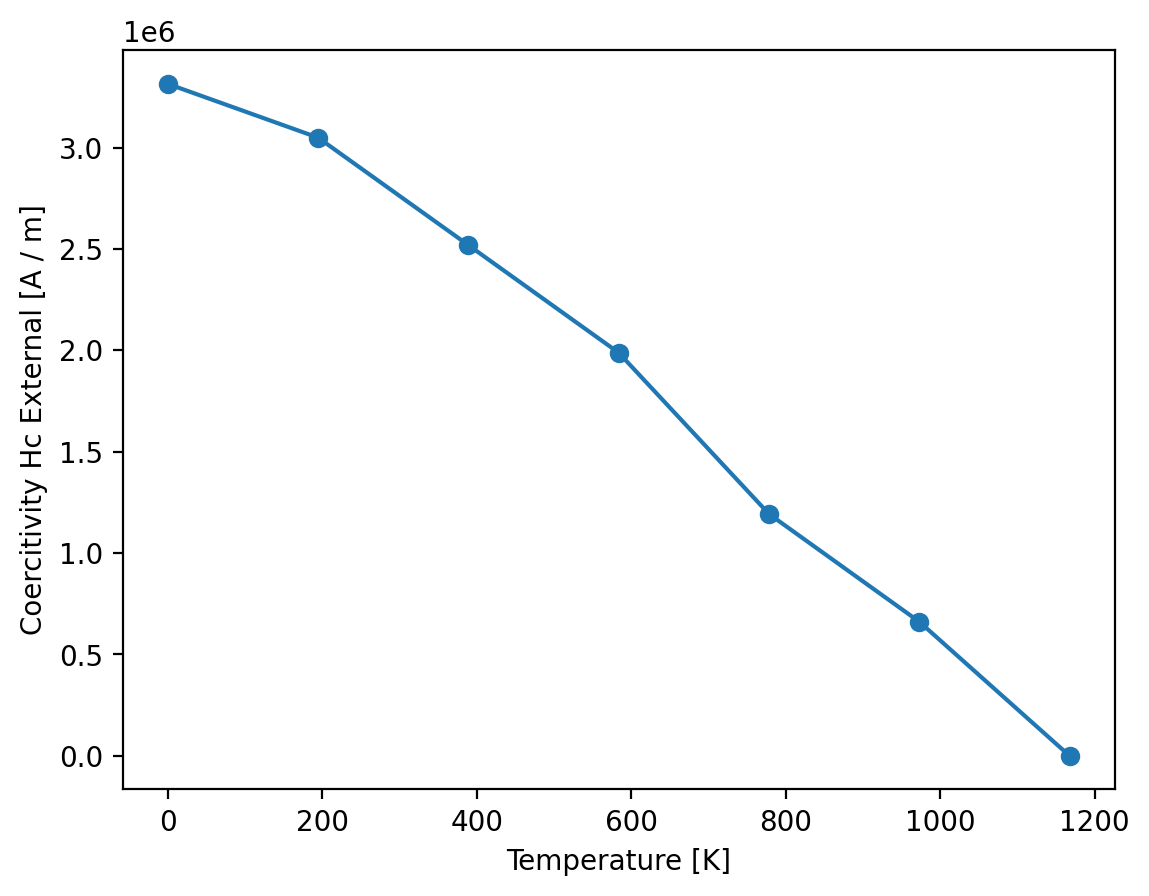

In [11]:
plt.plot(T, Hcs, linestyle="-", marker="o")
plt.xlabel("Temperature [K]")
plt.ylabel("Coercitivity Hc External [A / m]");

We can also show the hysteresis loops of all simulations:

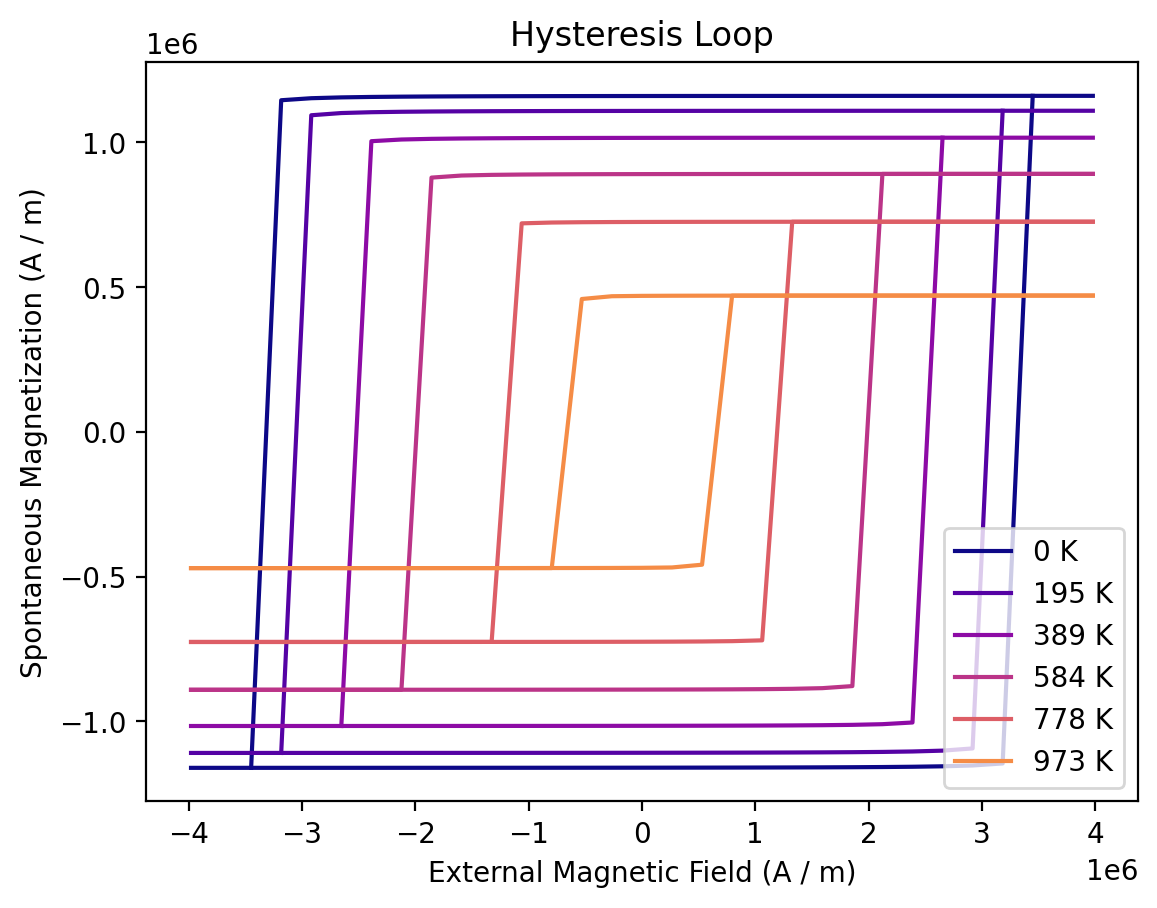

In [12]:
colors = colormaps["plasma"].colors[:: math.ceil(256 / len(T))]

fix, ax = plt.subplots()
for temperature, sim, color in zip(T, simulations, colors, strict=False):
    if np.isnan(sim.M.q).all():  # no Ms above Tc
        continue
    sim.plot(ax=ax, label=f"{temperature:.0f}", color=color, duplicate_change_color=False)
ax.legend(loc="lower right");